In [1]:
import Pkg
Pkg.activate(@__DIR__)
Pkg.instantiate()
import MathOptInterface as MOI
import Ipopt 
import FiniteDiff
import ForwardDiff
import Convex as cvx 
import ECOS
using LinearAlgebra
using Plots
using Random
using JLD2
using Test
import MeshCat as mc 

  Activating environment at `~/Documents/PlatformIO/Projects/Cartpole/Julia/Project.toml`


In [2]:
# import Pkg; Pkg.add("LibSerialPort")
# import Pkg; Pkg.add("TickTock")

using LibSerialPort
using TickTock
using Plots


list_ports()
ports = get_port_list()

/dev/cu.wlan-debug
	Description:	wlan-debug
	Transport type:	SP_TRANSPORT_NATIVE
/dev/cu.Bluetooth-Incoming-Port
	Description:	Bluetooth-Incoming-Port
	Transport type:	SP_TRANSPORT_NATIVE
/dev/cu.usbserial-56230387121
	Description:	USB Single Serial
	Transport type:	SP_TRANSPORT_NATIVE


3-element Vector{String}:
 "/dev/cu.wlan-debug"
 "/dev/cu.Bluetooth-Incoming-Port"
 "/dev/cu.usbserial-56230387121"

In [3]:
include(joinpath(@__DIR__, "utils","fmincon.jl"))
include(joinpath(@__DIR__, "utils","cartpole_animation.jl"))

animate_cartpole (generic function with 1 method)

**NOTE: This question will have long outputs for each cell, remember you can use `cell -> all output -> toggle scrolling` to better see it all**

## Q1: Direct Collocation (DIRCOL) for a Cart Pole (30 pts)

We are now going to start working with the NonLinear Program (NLP) Solver IPOPT to solve some trajectory optimization problems. First we will demonstrate how this works for simple optimization problems (not trajectory optimization). The interface that we have setup for IPOPT is the following:

$$ \begin{align} \min_{x} \quad & \ell(x) & \text{cost function}\\ 
 \text{st} \quad & c_{eq}(x) = 0 & \text{equality constraint}\\
 & c_L \leq c_{ineq}(x) \leq c_U & \text{inequality constraint}\\
 & x_L \leq x \leq x_U & \text{primal bound constraint}
 \end{align}$$
 
 where $\ell(x)$ is our objective function, $c_{eq}(x) = 0$ is our equality constraint, $c_L \leq c_{ineq}(x) \leq c_U$ is our bound inequality constraint, and $x_L \leq x \leq x_U $ is a bound constraint on our primal variable $x$. 
<!-- $$ \begin{align} \min_{x_{1:N},u_{1:N-1}} \quad & \sum_{i=1}^{N-1} \bigg[ \frac{1}{2} x_i^TQx_i + \frac{1}{2} u_i^TRu_i \bigg] + \frac{1}{2}x_N^TQ_fx_N\\ 
 \text{st} \quad & x_1 = x_{\text{IC}} \\ 
 & x_{i+1} = A x_i + Bu_i \quad \text{for } i = 1,2,\ldots,N-1 
 \end{align}$$ -->

## Part B: Cart Pole Swingup (20 pts)

We are now going to solve for a cartpole swingup. The state for the cartpole is the following: 

$$ x = [p,\theta,\dot{p},\dot{\theta}]^T $$ 

Where $p$ and $\theta$ can be seen in the graphic `cartpole.png`.

<div>
<img src="attachment:cartpole.png" width="300"/>
</div>

where we start with the pole in the down position ($\theta = 0$), and we want to use the horizontal force on the cart to drive the pole to the up position ($\theta = \pi$).

$$ \begin{align} \min_{x_{1:N},u_{1:N-1}} \quad & \sum_{i=1}^{N-1} \bigg[ \frac{1}{2} (x_i - x_{goal})^TQ(x_i - x_{goal}) + \frac{1}{2} u_i^TRu_i \bigg] + \frac{1}{2}(x_N - x_{goal})^TQ_f(x_N - x_{goal})\\ 
 \text{st} \quad & x_1 = x_{\text{IC}} \\ 
 & x_N = x_{goal} \\ 
 & f_{hs}(x_i,x_{i+1},u_i,dt) = 0 \quad \text{for } i = 1,2,\ldots,N-1 \\
 & -10 \leq u_i \leq 10 \quad \text{for } i = 1,2,\ldots,N-1 
 \end{align}$$
 
 Where $x_{IC} = [0,0,0,0]$, and $x_{goal} = [0, \pi, 0, 0]$, and $f_{hs}(x_i,x_{i+1},u_i)$ is the implicit integrator residual for Hermite Simpson (see HW1Q1 to refresh on this). Note that while Zac used a first order hold (FOH) on the controls in class (meaning we linearly interpolate controls between time steps), we are using a zero-order hold (ZOH) in this assignment. This means that each control $u_i$ is held constant for the entirety of the timestep. 

In [36]:
"""
continuous time dynamics for a cartpole, the state is 
x = [p, θ, ṗ, θ̇]
where p is the horizontal position, and θ is the angle
where θ = 0 has the pole hanging down, and θ = 180 is up.

The cartpole is parametrized by a cart mass `mc`, pole 
mass `mp`, and pole length `l`. These parameters are loaded 
into a `params::NamedTuple`. We are going to design the
controller for a estimated `params_est`, and simulate with 
`params_real`. 
"""
# cartpole 
function dynamics(params::NamedTuple, x, u)
    # cartpole ODE, parametrized by params. 

    # cartpole physical parameters 
    mc, mp, l = params.mc, params.mp, params.l
    g = 9.81
    
    q = x[1:2]
    qd = x[3:4]

    s = sin(q[2])
    c = cos(q[2])

    H = [mc+mp mp*l*c; mp*l*c mp*l^2]
    C = [0 -mp*qd[2]*l*s; 0 0]
    G = [0, mp*g*l*s]
    B = [1, 0]

    qdd = -H\(C*qd + G - B*u[1])
    xdot = [qd;qdd]
    return xdot 

end
function hermite_simpson(params::NamedTuple, x1::Vector, x2::Vector, u, dt::Real)::Vector
    # TODO: input hermite simpson implicit integrator residual 
    xmid = 0.5 * (x1 + x2) + (dt/8) * (dynamics(params,x1, u) - dynamics(params,x2, u))
    return x1 + ((dt/6) * (dynamics(params,x1, u) + 4*dynamics(params,xmid, u) + dynamics(params,x2, u))) - x2
end

hermite_simpson (generic function with 1 method)

To solve this problem with IPOPT and `fmincon`, we are going to concatenate all of our $x$'s and $u$'s into one vector:

$$ Z = \begin{bmatrix}x_1 \\ u_1 \\ x_2 \\ u_2 \\ \vdots \\ x_{N-1} \\ u_{N-1} \\ x_N \end{bmatrix} \in \mathbb{R}^{N \cdot nx + (N-1)\cdot nu} $$ 

where $x \in \mathbb{R}^{nx}$ and $u \in \mathbb{R}^{nu}$. Below we will provide useful indexing guide in `create_idx` to help you deal with $Z$.

It is also worth noting that while there are inequality constraints present ($-10 \leq u_i \leq 10$), we do not need a specific `inequality_constraints` function as an input to `fmincon` since these are just bounds on the primal ($Z$) variable. You should use primal bounds in `fmincon` to capture these constraints.  

In [199]:
function create_idx(nx,nu,N)
    # This function creates some useful indexing tools for Z 
    # x_i = Z[idx.x[i]]
    # u_i = Z[idx.u[i]]
    
    # Feel free to use/not use anything here.
    
    # our Z vector is [x0, u0, x1, u1, …, xN]
    nz = (N-1) * nu + N * nx # length of Z 
    x = [(i - 1) * (nx + nu) .+ (1 : nx) for i = 1:N]
    u = [(i - 1) * (nx + nu) .+ ((nx + 1):(nx + nu)) for i = 1:(N - 1)]
    
    # constraint indexing for the (N-1) dynamics constraints when stacked up
    c = [(i - 1) * (nx) .+ (1 : nx) for i = 1:(N - 1)]
    nc = (N - 1) * nx # (N-1)*nx 
    
    return (nx=nx,nu=nu,N=N,nz=nz,nc=nc,x= x,u = u,c = c)
end

function cartpole_cost(params::NamedTuple, Z::Vector)::Real
    idx, N, xg = params.idx, params.N, params.xg
    Q, R, Qf = params.Q, params.R, params.Qf
    
    # TODO: input cartpole LQR cost 
    
    J = 0 
    for i = 1:(N-1)
        xi = Z[idx.x[i]]
        ui = Z[idx.u[i]]

        x_dist = xi - xg

        x_cost = 0.5 * x_dist' * Q * x_dist
        u_cost = 0.5 * ui' * R * ui
       
        J += x_cost + u_cost 

    end
    
    # dont forget terminal cost 
    xn = Z[idx.x[N]]

    x_dist = xn - xg
    J += 0.5 * x_dist' * Qf * x_dist
    
    return J 
end

function cartpole_dynamics_constraints(params::NamedTuple, Z::Vector)::Vector
    idx, N, dt = params.idx, params.N, params.dt
    
    # TODO: create dynamics constraints using hermite simpson 
    
    # create c in a ForwardDiff friendly way (check HW0)
    c = zeros(eltype(Z), idx.nc)
    
    for i = 1:(N-1)
        xi = Z[idx.x[i]]
        ui = Z[idx.u[i]] 
        xip1 = Z[idx.x[i+1]]
        
        # TODO: hermite simpson 
        c[idx.c[i]] = hermite_simpson(params, xi, xip1, ui, dt)
    end
    return c 
end

function cartpole_equality_constraint(params::NamedTuple, Z::Vector)::Vector
    N, idx, xic, xg = params.N, params.idx, params.xic, params.xg 
    
    # TODO: return all of the equality constraints 
    
    # get x0 and xN
    x0 = Z[idx.x[1]]
    xN = Z[idx.x[N]]

    constraint1 = x0 - xic
    constraint2 = xN[1:4] - xg[1:4]
    dynamics = cartpole_dynamics_constraints(params, Z)

    c = [constraint1; constraint2; dynamics]

    return c
    # return zeros(10) # 10 is an arbitrary number 
end


function solve_cartpole_swingup(;verbose=true)
    
    # problem size 
    nx = 4 
    nu = 1 
    dt = 0.025
    tf = 6
    t_vec = 0:dt:tf 
    N = length(t_vec)
    
    # LQR cost 
    Q = diagm(ones(nx))
    R = 0.2*diagm(ones(nu))
    Qf = 10*diagm(ones(nx))
    
    # indexing 
    idx = create_idx(nx,nu,N)
    
    # initial and goal states 
    xic = [0, 0, 0, 0]
    xg = [0, pi, 0, 0]
    

    
    # TODO: primal bounds 
    println("N :", N)
    x_l = -Inf * ones(idx.nz)
    x_u = Inf * ones(idx.nz)
    for i = 1:(N-1)
        x_l[idx.u[i]] .= -30
        x_u[idx.u[i]] .= 30

        # # limit speed to 35 (working 20)
        x_l[idx.x[i][3]] = -0.30
        x_u[idx.x[i][3]] = 0.30

        # # limit travel to 30 cm
        x_l[idx.x[i][1]] = -0.35
        x_u[idx.x[i][1]] = 0.35
    end

    # print(x_l)

    # inequality constraint bounds (this is what we do when we have no inequality constraints)
    c_l = zeros(0)
    c_u = zeros(0)
    function inequality_constraint(params, Z)
        return zeros(eltype(Z), 0)
    end
    
    # initial guess 
    z0 = 0.01*randn(idx.nz)
    println("idx: ", idx)
    println("N: ", N)
    
    # choose diff type (try :auto, then use :finite if :auto doesn't work)
    diff_type = :auto 
#     diff_type = :finite
    
    # load all useful things into params 
    # params = (Q = Q, R = R, Qf = Qf, xic = xic, xg = xg, dt = dt, N = N, idx = idx,mc = 0.2, mp = 0.15, l = 0.35)
    params = (Q = Q, R = R, Qf = Qf, xic = xic, xg = xg, dt = dt, N = N, idx = idx,mc = 0.2, mp = 0.15, l = 0.35)
        
    Z = fmincon(cartpole_cost,cartpole_equality_constraint,inequality_constraint,
                x_l,x_u,c_l,c_u,z0,params, diff_type;
                tol = 1e-6, c_tol = 1e-6, max_iters = 10_000, verbose = verbose)
    
    # pull the X and U solutions out of Z 
    X = [Z[idx.x[i]] for i = 1:N]
    U = [Z[idx.u[i]] for i = 1:(N-1)]
    
    return X, U, t_vec
end

# @testset "cartpole swingup"

solve_cartpole_swingup (generic function with 1 method)

In [200]:
X, U, t_vec = solve_cartpole_swingup(verbose=true)

N :241
idx: (nx = 4, nu = 1, N = 241, nz = 1204, nc = 960, x = UnitRange{Int64}[1:4, 6:9, 11:14, 16:19, 21:24, 26:29, 31:34, 36:39, 41:44, 46:49, 51:54, 56:59, 61:64, 66:69, 71:74, 76:79, 81:84, 86:89, 91:94, 96:99, 101:104, 106:109, 111:114, 116:119, 121:124, 126:129, 131:134, 136:139, 141:144, 146:149, 151:154, 156:159, 161:164, 166:169, 171:174, 176:179, 181:184, 186:189, 191:194, 196:199, 201:204, 206:209, 211:214, 216:219, 221:224, 226:229, 231:234, 236:239, 241:244, 246:249, 251:254, 256:259, 261:264, 266:269, 271:274, 276:279, 281:284, 286:289, 291:294, 296:299, 301:304, 306:309, 311:314, 316:319, 321:324, 326:329, 331:334, 336:339, 341:344, 346:349, 351:354, 356:359, 361:364, 366:369, 371:374, 376:379, 381:384, 386:389, 391:394, 396:399, 401:404, 406:409, 411:414, 416:419, 421:424, 426:429, 431:434, 436:439, 441:444, 446:449, 451:454, 456:459, 461:464, 466:469, 471:474, 476:479, 481:484, 486:489, 491:494, 496:499, 501:504, 506:509, 511:514, 516:519, 521:524, 526:529, 531:534, 5

---------testing constraint Jacobian----------------


---------successfully compiled both derivatives-----


---------IPOPT beginning solve----------------------


This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:  1165472
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:     1204
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      720
                     variables with only upper bounds:        0
Total number of equality constraints.................:      968
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.2336242e+03 3.13e+00 9.42e-03   0.0 0.00e+00    -  0.00e+00 0.00e+00  

([[1.0230312190014537e-29, 5.221601968986422e-29, -6.42969676981604e-29, -4.2165677198887563e-29], [0.0001962395291527685, -0.0005598637828717278, 0.015659110324081137, -0.044609283075696], [0.0006616990418902985, -0.0018780083685898052, 0.021483342691239575, -0.060418887824528006], [0.0012194872214299985, -0.0034267121833860092, 0.023028913145693344, -0.06297998250407037], [0.0017944696849830917, -0.00496452976682556, 0.022859679724224265, -0.05955153625911169], [0.00235826784619687, -0.006383599142762001, 0.02214267935680737, -0.05351831460455958], [0.002903590073460593, -0.007638295930139407, 0.021393373827890427, -0.04645455366642664], [0.0034322645182989116, -0.008711889165395583, 0.02082381656857683, -0.039088209594460986], [0.003949672823891183, -0.009600953389140745, 0.02050528277265313, -0.031751496912194664], [0.0044621734192574715, -0.010308077322226408, 0.020444211221335835, -0.024591408244926276]  …  [-0.05869865047358715, 2.9411060617722087, 0.3000000099990696, 1.36651051

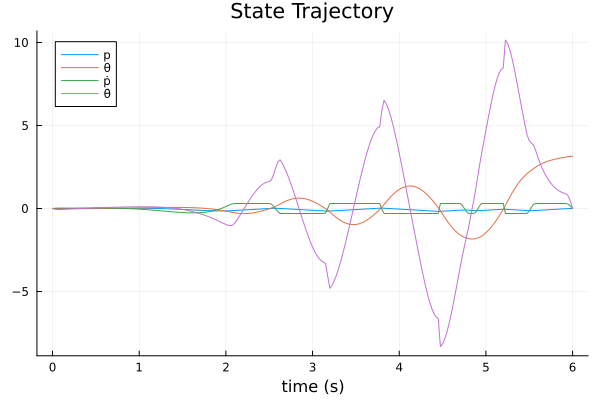

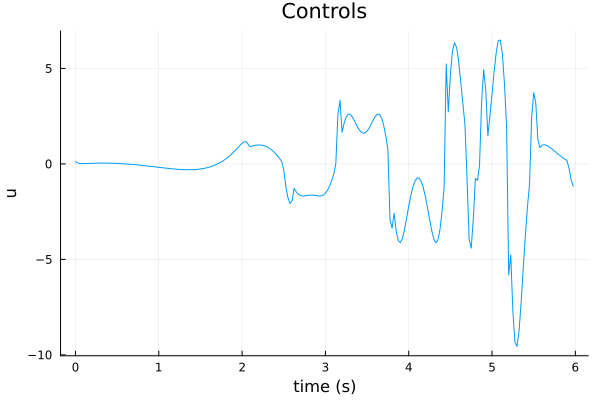

┌ Info: MeshCat server started. You can open the visualizer by visiting the following URL in your browser:
│ http://127.0.0.1:8701
└ @ MeshCat /Users/saraltayal/.julia/packages/MeshCat/Ax8pH/src/visualizer.jl:73


MeshCat.DisplayedVisualizer(MeshCat.CoreVisualizer(MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), UInt8[0x83, 0xa7, 0x6f, 0x70, 0x74, 0x69, 0x6f, 0x6e, 0x73, 0x82  …  0x5f, 0x61, 0x6e, 0x69, 0x6d, 0x61, 0x74, 0x69, 0x6f, 0x6e], Dict{String, MeshCat.SceneTrees.SceneNode}("meshcat" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("pole" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x73, 0x68, 0x63, 0x61, 0x74, 0x2f, 0x70, 0x6f, 0x6c, 0x65], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "b" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x2f, 0x6d, 0x65, 0x73, 0x68, 0x63, 0x61, 0x74, 0x2f, 0x62], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "cart" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x73, 0x68, 0x63, 0x61, 0x74, 0x2f, 0x63, 0x61, 0x72, 0x74], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "a" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x2f, 0x6d, 0x65, 0x73, 0x68, 0x63, 0x61, 0x74, 0x2f, 0x61], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()))))), Set{Any}(), ip"127.0.0.1", 8701))

In [201]:
# --------------plotting-----------------
Xm = hcat(X...)
Um = hcat(U...)

display(plot(t_vec, Xm', label = ["p" "θ" "ṗ" "θ̇"], xlabel = "time (s)", title = "State Trajectory"))
# display(plot(t_vec, (Xm[3,:])', label = "ṗ", xlabel = "time (s)", title = "State Trajectory"))
display(plot(t_vec[1:end-1],Um',label="",xlabel = "time (s)", ylabel = "u",title = "Controls"))

# meshcat animation
display(animate_cartpole(X, 0.05))

In [67]:
jldsave("cartpole_swingup_backup_best2.jld2"; X, U, t_vec)

In [202]:
# saveFile = jldopen("cartpole_swingup_altro3.jld2", "r")
# X_save= read(saveFile, "Xopt")
# U_save = read(saveFile, "Uopt")

# println("X_save: ", X_save)

In [203]:
# X = X_save
# U = U_save

## Part C: Track DIRCOL Solution (5 pts)

Now, similar to HW2 Q2 Part C, we are taking a solution $X$ and $U$ from DIRCOL, and we are going to track the trajectory with TVLQR to account for model mismatch. While we used hermite-simpson integration for the dynamics constraints in DIRCOL, we are going to use RK4 for this simulation. Remember to clamp your control to be within the control bounds. 

In [204]:
function ihlqr(A::Matrix,       # vector of A matrices 
    B::Matrix,       # vector of B matrices
    Q::Matrix,       # cost matrix Q 
    R::Matrix;       # cost matrix R 
    max_iter = 1000, # max iterations for Ricatti 
    tol = 1e-3       # convergence tolerance
    )::Tuple{Matrix, Matrix} # return two matrices 

    # get size of x and u from B 
    nx, nu = size(B)

    # initialize S with Q
    P = deepcopy(Q)
    K = deepcopy(Q)

    # Ricatti 
    for ricatti_iter = 1:max_iter 
        K = (R + B'*P*B)\(B'*P*A)
        Pnew = Q + A'*P*(A-B*K)
        if norm(P - Pnew) < tol 
            break
        end
        
        # print("ihlqr iteration: ", ricatti_iter, " norm(P - Pnew) = ", norm(P - Pnew), "\n")
        P = deepcopy(Pnew)
        if ricatti_iter == max_iter
        error("ihlqr did not converge")
        end
    end

    return P, K
end

ihlqr (generic function with 1 method)

In [205]:
ENCODER_LINEAR_ANGULAR_RATIO_CM = 0.6389; # Old: 0.602
ENCODER_LINEAR_ANGULAR_RATIO_M = ENCODER_LINEAR_ANGULAR_RATIO_CM / 100; # Old: 0.00602
ENCODER_ELBOW_ANGULAR_RATIO= 0.2;
ENCODER_SHOULDER_ANGULAR_RATIO = 1.0;
MOTOR_LINEAR_RPM_TO_CMPS = 50; 
CM_TO_M = 0.01
M_TO_CM = 100

decode_list = [
"linear_position", 
"linear_velocity", 
"shoulder_position", 
"shoulder_velocity", 
"elbow_position", 
"elbow_velocity",
"requested_vel_1",
"requested_vel_2",
"serial_tx_time",
# "time_since_last_command",
]

# takes inputs in m/s for cart
function write_motors(sp, linear_vel, elbow_vel)
    # max prescision of 3 decimal places
    linear_vel = round(linear_vel * MOTOR_LINEAR_RPM_TO_CMPS * M_TO_CM, digits=3) 
    elbow_vel = round(elbow_vel, digits=3)
    string_to_write = "<" * string(linear_vel) * ", " * string(elbow_vel) * ">"
    write(sp, string_to_write)
end


# Forward declare for runtime optimization
length_decode = length(decode_list)
length_decode_min_1 = length_decode - 1
length_decode_plus_1 = length_decode + 1

# returns in m/s
function safe_read(sp)
    timeout = 10
    while(timeout > 0)
        encoderData = readline(sp)
        try # catch byte errors in encoderData.decode
            encoderData = split(encoderData, ",")
            encoderData = encoderData[1:length_decode]
            encoderData = [parse(Float64, x) for x in encoderData]
            if length(encoderData) == length_decode # account for the \r\n 
                encoderData[1] *= -ENCODER_LINEAR_ANGULAR_RATIO_CM
                encoderData[2] *= -ENCODER_LINEAR_ANGULAR_RATIO_CM

                encoderData[1] *= CM_TO_M
                encoderData[2] *= CM_TO_M
                encoderData[7] *= CM_TO_M

                sp_flush(sp, SP_BUF_BOTH)
                return encoderData
            end
            timeout -= 1
            # println("Timeout during Read 1")
        catch
            timeout -= 1
            # println("Timeout during Read 0")
        end
    end
    println("Timeout during Read")
end

function busy_sleep(time_s)
    start = time()
    while (time() - start) < time_s
    end
end

busy_sleep (generic function with 1 method)

In [493]:
function rk4(params::NamedTuple, x,u,dt::Float64)
    # vanilla RK4
    k1 = dt*dynamics(params, x, u)
    k2 = dt*dynamics(params, x + k1/2, u)
    k3 = dt*dynamics(params, x + k2/2, u)
    k4 = dt*dynamics(params, x + k3, u)
    x + (1/6)*(k1 + 2*k2 + 2*k3 + k4)
end

# @testset "track cartpole swingup with TVLQR" begin 
# ENCODER_LINEAR_ANGULAR_RATIO_M = 0.00602;
# ENCODER_LINEAR_ANGULAR_RATIO_CM = 0.602;
# ENCODER_ELBOW_ANGULAR_RATIO= 0.2;
# ENCODER_SHOULDER_ANGULAR_RATIO = 1.0;

# X_dircol, U_dircol, t_vec, params_dircol = solve_cartpole_swingup(verbose = false)
X_dircol = X
U_dircol = U

# speed_mult = 22222
nx = 4 
nu = 1 
dt = 0.025
tf = 6
t_vec = 0:dt:tf 
N = length(t_vec)

# LQR cost 
Q = diagm(ones(nx))
R = 0.1*diagm(ones(nu))
Qf = 10*diagm(ones(nx))

# indexing 
idx = create_idx(nx,nu,N)

# initial and goal states 
xic = [0, 0, 0, 0]
xg = [0, pi, 0, 0]
params_dircol = (Q = Q, R = R, Qf = Qf, xic = xic, xg = xg, dt = dt, N = N, idx = idx,mc = 0.4, mp = 0.2, l = 0.35)

# N = length(X_dircol)
dt_dircol = params_dircol.dt 
x0 = X_dircol[1]
u0 = U_dircol[1]
N_dircol = length(X_dircol)
t_vec_dircol = 0:dt_dircol:tf

# use this for TVLQR tracking cost 
Q = diagm([1,1,.05,.1])
Qf = 100*Q
R = 0.0001*diagm(ones(1))

# use TVLQR to generate K's 
# A = ForwardDiff.jacobian(dx -> rk4(params_dircol, dx, u0, dt), x0)
# B = ForwardDiff.jacobian(du -> rk4(params_dircol, x0, du, dt), u0) 
# Q = diagm([0,0,1,1])
# R = 0.01*diagm(ones(1))
# P, K = ihlqr(A, B, Q, R)

# simulation
Xsim = [zeros(4) for i = 1:N]
Usim = [zeros(1) for i = 1:(N-1)]
Xsim[1] = 1*x0 

velocity = [x[3] for x in X_dircol]

linearPositions = zeros(N)
elbowPositions = zeros(N)
linearVelocities = zeros(N)
elbowVelocities = zeros(N)
shoulderPositions = zeros(N)
shoulderVelocities = zeros(N)
elbowRequested = zeros(N)
linearRequested = zeros(N)
linearRequestedFeedback = zeros(N)
loop_time_ms_array = zeros(N)
loop_time_ms_array_2 = zeros(N)

println(N)
println(length(velocity))
println(length(velocity))
println(dt_dircol)


# velocities_strings = ["0.0" for i = 1:N]
# for i = 1:N
#     index = floor(Int, i / freq) + 1
#     velocities_strings[i] = string(round(velocity[index] * speed_mult, digits=1))
# end


# end

241
241
241
0.025


In [558]:

M_TO_CM = 100
sp = LibSerialPort.open("/dev/cu.usbserial-56230387121", 256000)
set_flow_control(sp)
sp_flush(sp, SP_BUF_BOTH)
write_motors(sp, 0, 0)
encoder_data = safe_read(sp)

linearBaseLine = encoder_data[1] 
shoulderBaseLine = encoder_data[3]
# shoulderBaseLine = 0.35
println("linearBaseLine: ", linearBaseLine)
println("shoulderBaseLine: ", shoulderBaseLine)

# TODO: simulate closed loop system 
x_sim_i = [encoder_data[1], encoder_data[3], encoder_data[2], encoder_data[4]]
K = zeros(1,4)

tick()
for i = 1:(N-1)
    start_iter = time()
    # # feeback control
    # u_i = U_dircol[i] - 0.1 * K*(x_sim_i - X_dircol[i])
    # # u_i = clamp.(u_i, -10, 10) # update this

    # Usim[i] = u_i
    # x_new = rk4(params, Xsim[i], Usim[i], dt) 

    # println(i)
    speed = clamp(velocity[i], -0.38, 0.38)
    # speed = clamp(x_new[3], -0.35, 0.35)
    write_motors(sp, speed, 0)
    encoder_data = safe_read(sp)
    
    linearPositions[i] = encoder_data[1] - linearBaseLine
    linearVelocities[i] = encoder_data[2]
    shoulderPositions[i] = encoder_data[3] - shoulderBaseLine
    shoulderVelocities[i] = encoder_data[4]
    elbowPositions[i] = encoder_data[5]
    elbowVelocities[i] = encoder_data[6]
    linearRequested[i] = encoder_data[7]
    elbowRequested[i] = encoder_data[8]
    # linearRequestedFeedback[i] = x_new[3]

    x_sim_i = [linearPositions[i], shoulderPositions[i], linearVelocities[i], shoulderVelocities[i]]
    Xsim[i] = x_sim_i

    # Feedback after a new state
    # A = ForwardDiff.jacobian(dx -> rk4(params, dx, u_i, dt), x_sim_i)
    # B = ForwardDiff.jacobian(du -> rk4(params, x_sim_i, du, dt), u_i)
    # P, K = ihlqr(A, B, Q, R)
    # Feedback after a new state

    loop_time_ms = (time() - start_iter)
    loop_time_ms_array[i] = loop_time_ms
    time_to_sleep = max(dt - loop_time_ms, 0)
    busy_sleep(time_to_sleep) # micro seconds
    loop_time_ms_2 = (time() - start_iter)
    loop_time_ms_array_2[i] = loop_time_ms_2
end
tock()

write_motors(sp, 0, 0)
close(sp)

linearBaseLine: 0.016975573
shoulderBaseLine: 1.239


┌ Info:  started timer at: 2023-08-03T07:30:20.190
└ @ TickTock /Users/saraltayal/.julia/packages/TickTock/fGILW/src/TickTock.jl:54
┌ Info:          6.108898458s: 6 seconds, 108 milliseconds
└ @ TickTock /Users/saraltayal/.julia/packages/TickTock/fGILW/src/TickTock.jl:62


In [559]:
# shift Xsim to the left by 3 time_steps
Xsim_raw = copy(Xsim)
time_step_shift = 4
Xshift = Xsim[time_step_shift+1:end]
append!(Xshift, [Xsim[end]])
append!(Xshift, [Xsim[end]])
append!(Xshift, [Xsim[end]])
append!(Xshift, [Xsim[end]])
Xsim = Xshift;

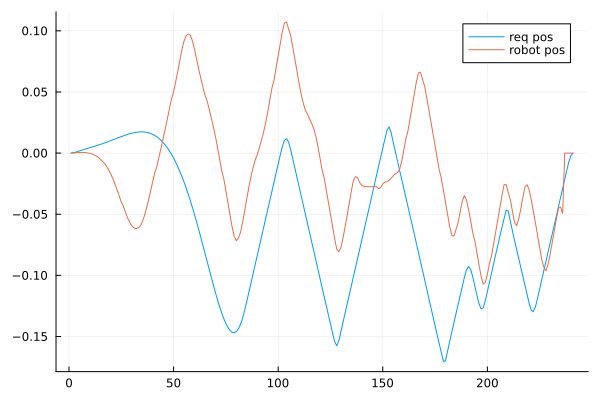

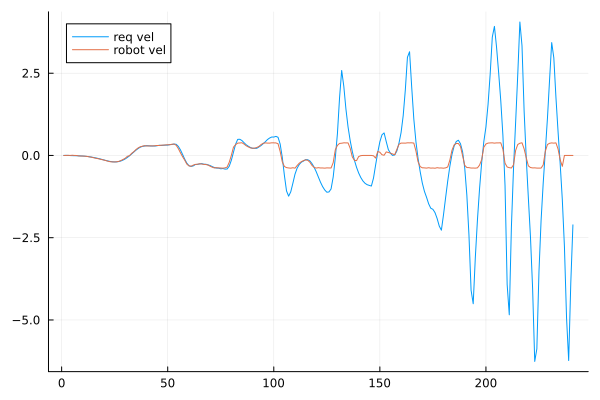

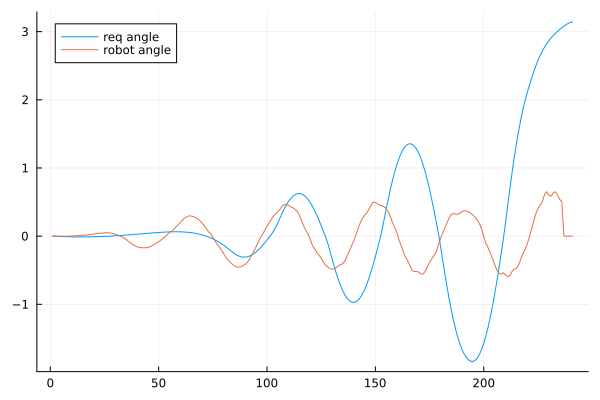

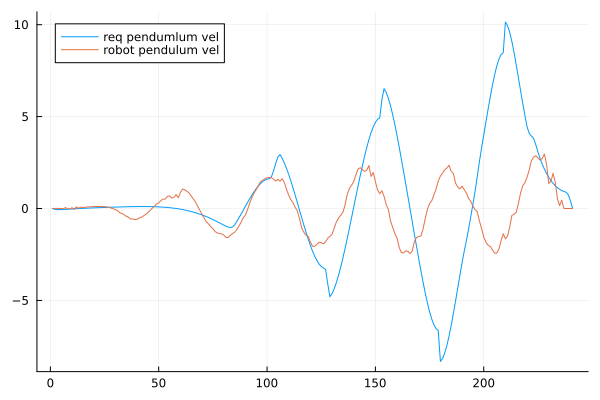

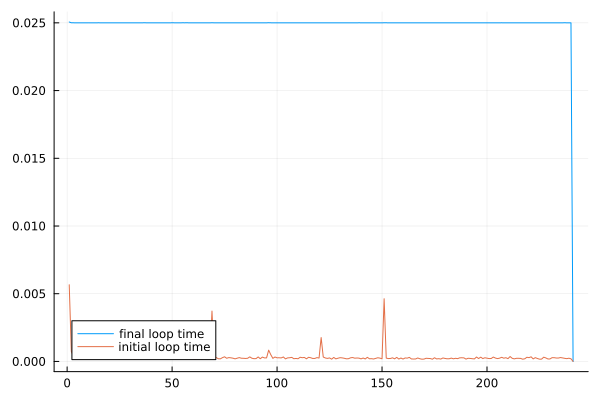

In [560]:
plot_x = hcat(Xsim...)

plt = plot(Xm[1,:], label = "req pos")
plot!(plot_x[1,:], label = "robot pos")
display(plt)
gui()

plt2 = plot(velocity, label = "req vel")
# plot!(linearRequestedFeedback, label = "feedback vel")
# plot the next line as a dot plot
# scatter!(linearRequested, label = "req vel")
# plot!(linearRequested, label = "input vel")
plot!(plot_x[3,:], label = "robot vel")
display(plt2)

plt3 = plot(Xm[2,:], label = "req angle")
plot!(plot_x[2,:], label = "robot angle")
display(plt3)

plt4 = plot(Xm[4,:], label = "req pendumlum vel")
plot!(plot_x[4,:], label = "robot pendulum vel")
display(plt4)

# plt5 = plot(feedback_calculation, label = "feedback_calculation")
# display(plt5)

plt6 = plot(loop_time_ms_array_2, label = "final loop time")
plot!(loop_time_ms_array, label = "initial loop time")
display(plt6)

In [550]:
import Convex as cvx 
import ECOS
using Printf
# Xsim_safe = copy(Xsim);
# Xsim = copy(Xsim_safe);

In [561]:
# feel free to use/not use any of these 

function trajectory_cost(Xsim::Vector{Vector{Float64}}, # simulated states 
    Ubar::Vector{Vector{Float64}}, # simulated controls (ILC iterates this)
    Xref::Vector{Vector{Float64}}, # reference X's we want to track
    Uref::Vector{Vector{Float64}}, # reference U's we want to track 
    Q::Matrix,                     # LQR tracking cost term 
    R::Matrix,                     # LQR tracking cost term
    Qf::Matrix                     # LQR tracking cost term
    )::Float64                     # return cost J 

J = 0 

N = length(Xsim)

for i = 1:N-1
xdiff = Xsim[i] - Xref[i]
J += (Xsim[i] - Xref[i])' * Q * (Xsim[i] - Xref[i]) + (Ubar[i] - Uref[i])' * R * (Ubar[i] - Uref[i])
end
J += (Xsim[end] - Xref[end])' * Qf * (Xsim[end] - Xref[end])

return J

end

function vec_from_mat(Xm::Matrix)::Vector{Vector{Float64}}
# convert a matrix into a vector of vectors 
X = [Xm[:,i] for i = 1:size(Xm,2)]
return X 
end

function ilc_update(Xsim::Vector{Vector{Float64}}, # simulated states 
Ubar::Vector{Vector{Float64}}, # simulated controls (ILC iterates this)
Xref::Vector{Vector{Float64}}, # reference X's we want to track
Uref::Vector{Vector{Float64}}, # reference U's we want to track 
As::Vector{Matrix{Float64}},   # vector of A jacobians at each time step 
Bs::Vector{Matrix{Float64}},   # vector of B jacobians at each time step 
Q::Matrix,                     # LQR tracking cost term 
R::Matrix,                     # LQR tracking cost term
Qf::Matrix,                    # LQR tracking cost term
params
)::Vector{Vector{Float64}}     # return vector of ΔU's 

# solve optimization problem for ILC update
N = length(Xsim)
nx,nu = size(Bs[1])

# create variables 
ΔX = cvx.Variable(nx, N)
ΔU = cvx.Variable(nu, N-1)

# TODO: cost function (tracking cost on Xref, Uref)
cost = 0
for i = 1:N-1
    xdiff = (Xsim[i] - Xref[i]) + ΔX[:,i]
    udiff = (Ubar[i] - Uref[i]) + ΔU[:,i]
    # udiff = (Ubar[i]) + ΔU[:,i]

    state_cost = cvx.quadform(xdiff, Q)
    control_cost = cvx.quadform(udiff, R)
    # control_cost = cvx.quadform(udiff + Ubar[i][1], R) + (0.5 * cvx.quadform(udiff, R))
    # control_cost = cvx.quadform(udiff + Ubar[i][1], R) 

    cost += state_cost + control_cost
end
final_state_cost = cvx.quadform((Xsim[end] - Xref[end]) + ΔX[:,end], Qf)
cost += final_state_cost

# problem instance 
prob = cvx.minimize(cost)

# TODO: initial condition constraint
prob.constraints += ΔX[:,1] == 0

# TODO: dynamics constraints
# for i = 1:N-1
for i = 1:200
    prob.constraints += ΔX[:,i+1] == As[i]*ΔX[:,i] + Bs[i]*ΔU[:,i]
    prob.constraints += Xsim[i][3] + ΔX[:,i][3] < 0.3
    prob.constraints += Xsim[i][3] + ΔX[:,i][3] > -0.3
    prob.constraints += Xsim[i][1] + ΔX[:,i][1] <= 0.35
    prob.constraints += Xsim[i][1] + ΔX[:,i][1] >= -0.35
    prob.constraints += Ubar[i] + ΔU[:,i] <= 5
    prob.constraints += Ubar[i] + ΔU[:,i] >= -5
end

cvx.solve!(prob, ECOS.Optimizer; silent_solver = true)

# return ΔU 
ΔU = vec_from_mat(ΔU.value)

return ΔU
end

ilc_update (generic function with 2 methods)

In [562]:

    # optimal trajectory computed offline with approximate model 
    Xref, Uref = Xm, Um
    
    # initial and terminal conditions 
    xic = Xref[1]
    xg = Xref[N]
    
    # LQR tracking cost to be used in ILC 
    # Q = diagm([0.1, 2, 0.1, 0.2,])
    Q = diagm([0, 10, 0, 1,])
    R = 2*diagm(ones(nu))
    Qf = Q 
    
    # load all useful things into params 
    params = (Q = Q, R = R, Qf = Qf,xic = xic, xg = xg, Xref=Xref,Uref=Uref,
          dt = dt,
          N = N,
          model = dynamics, 
          mc = 0.2, mp = 0.35, l = 0.35)
    
    # this is the feedforward control ILC is updating 
    # Ubar = [zeros(nu) for i = 1:(N-1)]
    # for i = 1:N-1
    #     Ubar[i][1] = Uref[i]
    # end
    
    # TODO: calculate Jacobians 
    As = [zeros(nx, nx) for i = 1:N-1]
    Bs = [zeros(nu, nu) for i = 1:N-1]

    @printf("Pre Calculating Jacobians... \n")
    for i = 1:N-1
        As[i] = ForwardDiff.jacobian(dx -> rk4(params, dx, Uref[i], dt), Xref[:,i])
        Bs[i] = ForwardDiff.jacobian(du -> rk4(params, Xref[:,i], du, dt), [Uref[i]])
        # As[i] = ForwardDiff.jacobian(dx -> rk4(params, dx, Ubar[i][1], dt), Xsim[i]) 
        # Bs[i] = ForwardDiff.jacobian(du -> rk4(params, Xsim[i], du, dt), [Ubar[i][1]])
    end

    Xref_vec = vec_from_mat(Xref)
    Uref_vec = vec_from_mat(Uref)
    println("Running ilc")    
    ΔU = ilc_update(Xsim, Ubar, Xref_vec, Uref_vec, As, Bs, Q, R, Qf, params);
    Ubar = Ubar + ΔU;

Pre Calculating Jacobians... 
Running ilc

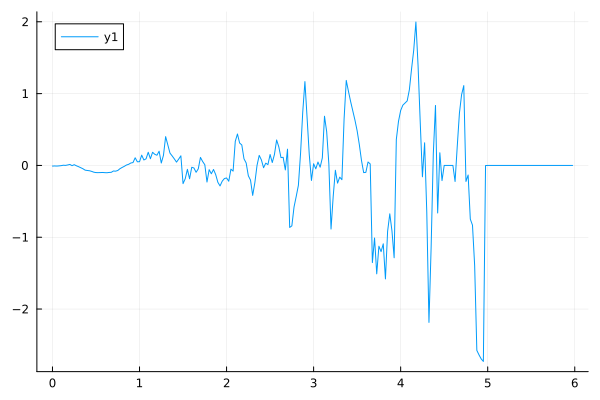

In [563]:
d_u_plt = hcat(ΔU...)
plot(t_vec[1:end-1], d_u_plt')

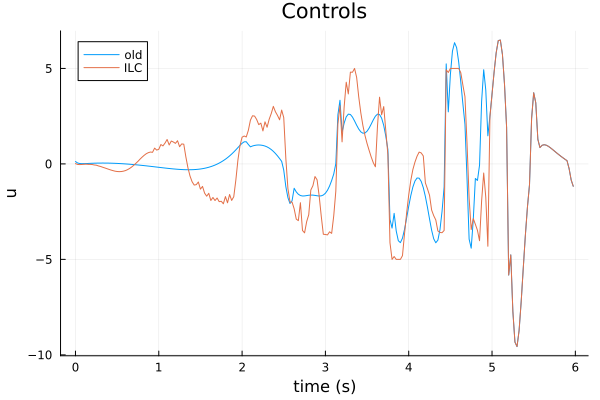

In [564]:
Ubar_plt = hcat(Ubar...)
plot(t_vec[1:end-1],Um',xlabel = "time (s)", ylabel = "u",title = "Controls", label = "old")
plot!(t_vec[1:end-1],Ubar_plt',xlabel = "time (s)", ylabel = "u", label = "ILC")

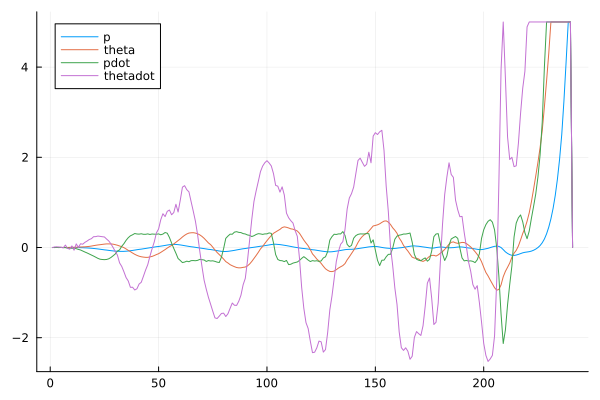

In [565]:
# add ILC to the simulation
X_ilc = [zeros(4) for i = 1:N]
ΔX = zeros(4)
for i = 1:(N-1)
    ΔX = As[i]*ΔX + Bs[i]*ΔU[i]
    X_ilc[i] = clamp!(Xsim[i] + ΔX, -5, 5)
end

plot_x = hcat(X_ilc...)
plot(plot_x[1,:], label = "p")
plot!(plot_x[2,:], label = "theta")
plot!(plot_x[3,:], label = "pdot")
plot!(plot_x[4,:], label = "thetadot")

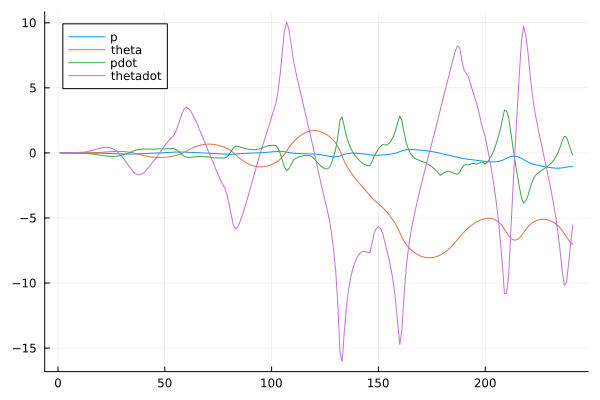

In [566]:
# do a rollout with ubar
X_ilc = [zeros(4) for i = 1:N]
for i = 1:(N-1)
    X_ilc[i+1] = rk4(params, X_ilc[i, :][1], Ubar[i][1], dt)
end

plot_x = hcat(X_ilc...)
plot(plot_x[1,:], label = "p")
plot!(plot_x[2,:], label = "theta")
plot!(plot_x[3,:], label = "pdot")
plot!(plot_x[4,:], label = "thetadot")


In [557]:
velocity = [x[3] for x in X_ilc]

241-element Vector{Float64}:
  0.0
  0.003324166302508083
  0.0008193760658119689
 -0.0025029535146312656
 -0.0053232985692511885
 -0.007303500276513303
 -0.00885319667181636
 -0.010972592491132156
 -0.013878930991337433
 -0.018053314052897278
  ⋮
  1.76292731287807
  0.7202668853828786
 -0.2572830539403852
 -1.3421496650064406
 -2.7704672638924515
 -4.940069522434678
 -6.232899256439749
 -3.8693197136814503
 -2.1087952942746595

In [ ]:
# thought experiment: Write an optimization problem that tunes the parameters to find the closest parameters to what the trajectory simulated was (diff = x_real(params_opt) - x_real)

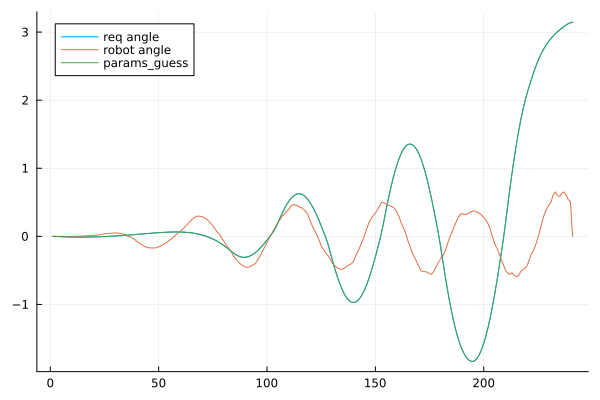

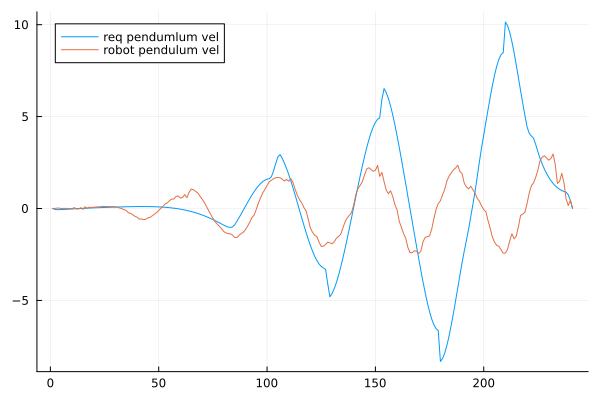

In [567]:
# do a rollout with ubar
# params = (Q = Q, R = R, Qf = Qf, xic = xic, xg = xg, dt = dt, N = N, idx = idx,mc = 0.2, mp = 0.15, l = 0.35)
# params = (Q = Q, R = R, Qf = Qf, xic = xic, xg = xg, dt = dt, N = N, idx = idx, mc = 0.2, mp = 0.15, l = 0.35)
params_mod = (Q = Q, R = R, Qf = Qf, xic = xic, xg = xg, dt = dt, N = N, idx = idx,mc = 0.2, mp = 0.35, l = 0.35)

scalar = 1

X_ilc = [zeros(4) for i = 1:N]
for i = 1:(N-1)
    X_ilc[i+1] = rk4(params_mod, X_ilc[i, :][1], U[i][1] * scalar, dt)
end

plot_x = hcat(X_ilc...)

plt3 = plot(Xm[2,:], label = "req angle")
plot!(shoulderPositions, label = "robot angle")
plot!(plot_x[2,:], label = "params_guess")
display(plt3)

plt4 = plot(Xm[4,:], label = "req pendumlum vel")
plot!(shoulderVelocities, label = "robot pendulum vel")
# plot!(plot_x[4,:], label = "params_guess")
display(plt4)


#### LQR experimentation

In [581]:
X_bal = [0,0,pi, 0]
A = ForwardDiff.jacobian(dx -> rk4(params_mod, dx, 0, dt), X_bal)
B = ForwardDiff.jacobian(du -> rk4(params_mod, X_bal, du, dt), [0])
Q = diagm([0, 1, 0, 0,])
R = 0.5*diagm(ones(1))

K_ilqr = ihlqr(A, B, Q, R)[2]

1×4 Matrix{Float64}:
 0.0  -0.0293368  0.0  -0.153021

In [598]:
M_TO_CM = 100
sp = LibSerialPort.open("/dev/cu.usbserial-56230387121", 256000)
set_flow_control(sp)
sp_flush(sp, SP_BUF_BOTH)
write_motors(sp, 0, 0)
encoder_data = safe_read(sp)

U_vec = zeros(N)
speeds = zeros(N)
linearBaseLine = encoder_data[1] 
shoulderBaseLine = encoder_data[3]
shoulderBaseLine = 1.236
println("linearBaseLine: ", linearBaseLine)
println("shoulderBaseLine: ", shoulderBaseLine)

# TODO: simulate closed loop system 
x_sim_i = [encoder_data[1], encoder_data[3], encoder_data[2], encoder_data[4]]
K = zeros(1,4)

tick()
for i = 1:(N-1)
    start_iter = time()
# measure state, calculate feedback, send input

    encoder_data = safe_read(sp)
    
    linearPositions[i] = encoder_data[1] - linearBaseLine
    linearVelocities[i] = encoder_data[2]
    shoulderPositions[i] = encoder_data[3] - shoulderBaseLine
    shoulderVelocities[i] = encoder_data[4]
    elbowPositions[i] = encoder_data[5]
    elbowVelocities[i] = encoder_data[6]
    linearRequested[i] = encoder_data[7]
    elbowRequested[i] = encoder_data[8]
    # linearRequestedFeedback[i] = x_new[3]

    x_sim_i = [linearPositions[i], shoulderPositions[i], linearVelocities[i], shoulderVelocities[i]]
    Xsim[i] = x_sim_i

    # feeback control
    u_i = - 1 * K_ilqr*(x_sim_i - X_bal)
    u_i = clamp.(u_i, -10, 10) # update this
    U_vec[i] = u_i[1]

    x_new = rk4(params, Xsim[i], u_i, dt) 

    speed = clamp(velocity[i], -0.38, 0.38)
    write_motors(sp, speed, 0)
    speeds[i] = speed

    loop_time_ms = (time() - start_iter)
    loop_time_ms_array[i] = loop_time_ms
    time_to_sleep = max(dt - loop_time_ms, 0)
    busy_sleep(time_to_sleep) # micro seconds
    loop_time_ms_2 = (time() - start_iter)
    loop_time_ms_array_2[i] = loop_time_ms_2
end
tock()

write_motors(sp, 0, 0)
close(sp)

linearBaseLine: -0.048581956
shoulderBaseLine: 1.236


┌ Info:  started timer at: 2023-08-03T08:01:00.279
└ @ TickTock /Users/saraltayal/.julia/packages/TickTock/fGILW/src/TickTock.jl:54
┌ Info:          6.083204917s: 6 seconds, 83 milliseconds
└ @ TickTock /Users/saraltayal/.julia/packages/TickTock/fGILW/src/TickTock.jl:62


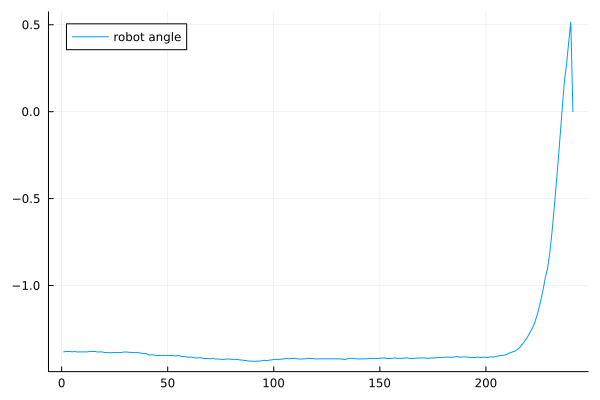

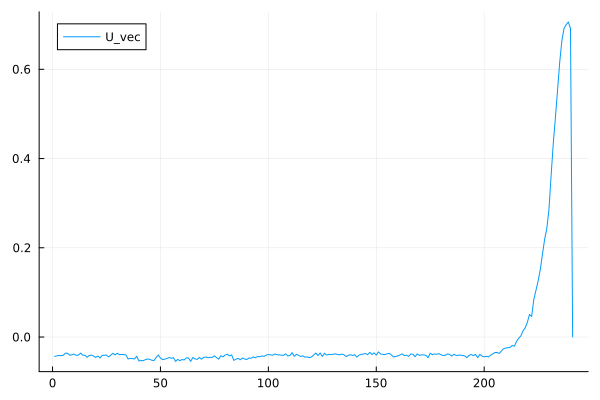

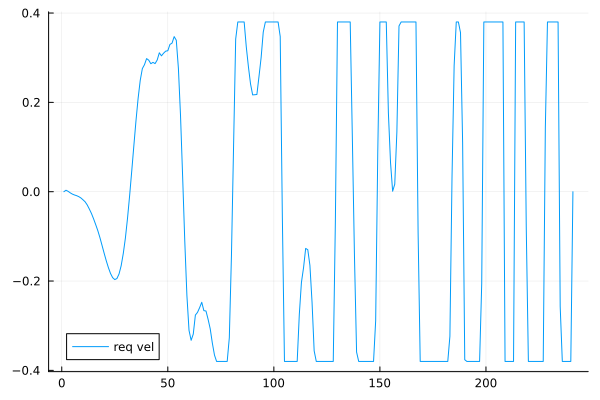

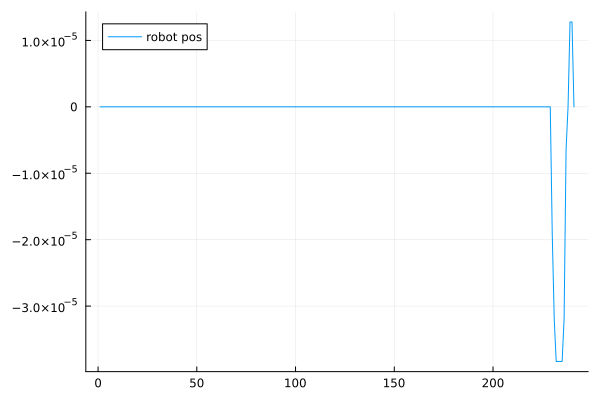

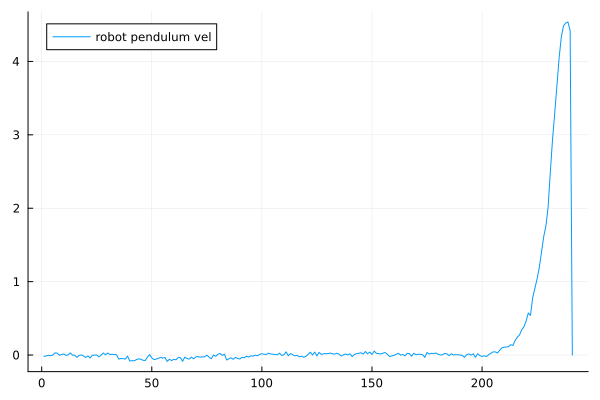

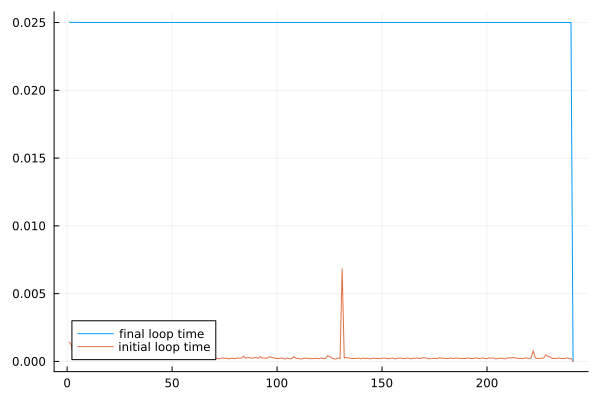

In [599]:
plot_x = hcat(Xsim...)

plt3 = plot(plot_x[2,:], label = "robot angle")
display(plt3)

plt1 = plot(U_vec, label = "U_vec")
display(plt1)

plt2 = plot(speeds, label = "req vel")
display(plt2)

plt = plot(plot_x[1,:], label = "robot pos")
display(plt)
gui()


plt4 = plot(plot_x[4,:], label = "robot pendulum vel")
display(plt4)

plt6 = plot(loop_time_ms_array_2, label = "final loop time")
plot!(loop_time_ms_array, label = "initial loop time")
display(plt6)